# Relevant Imports

In [9]:
import math
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from confeddi import FederatedSystem
from distribute_data import generate_data
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Preprocess Data

### Load RTT Data

In [10]:
data = pd.read_csv('RTT_data.csv')

# Getting rid of complex-valued columns
data = data.select_dtypes(exclude = ['object'])

# Quick look at data
print(f'Number of samples: {data.shape[0]}')
print(f'Features per sample: {data.shape[1] - 1}\n')
print(f'Columns:')
for i in data.columns[:-1]:
    if i == 'GroundTruthRange[m]':
        continue
    print(f'{i}, ', end = '')
print(data.columns[-1], end = '')


# Separate data and labels
X = data.drop(columns = ['GroundTruthRange[m]']).to_numpy()
y = data['GroundTruthRange[m]'].to_numpy()

Number of samples: 29581
Features per sample: 10

Columns:
%Timestamp[s], GroundTruthPositionX[m], GroundTruthPositionY[m], GroundTruthPositionZ[m], ML_range_estimate[m], AP_positionX[m], AP_positionY[m], AP_positionZ[m], AP_index, ToD_factor[m]

### Distribute data among clients

In [11]:
seed = 11

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = seed)

data = generate_data(X_train, y_train, seed = seed)
scaler = StandardScaler()
X_val = scaler.fit_transform(X_val)
X = scaler.fit_transform(X)

fed = FederatedSystem(data['Client Data'], data['Client Labels'], data['Client Distances'])
fed.SetValData({'Val Data': X_val, 'Val Labels': y_val})
fed.SetTestData({'Data': X, 'Labels': y})

In [12]:
tf.keras.utils.set_random_seed(50)
tf.config.experimental.enable_op_determinism()
# 4 before
Mt = (np.ones(50) * 5).astype('int32')
fed.SetContextElements([2, 3])
w, b = fed.ConFeddi(0.1, 0.01, rounds = 50, Mt = Mt)

range(0, 10)
[7 8 0 2 3 5 6 1 9 4]
[8 2 7 6]
[8 7 6 2]
Round 5
[7 8]
[7 8 6 2 5 0 3 1 9 4]
[7 6 2 8 9 1]
[6 2 7 9 1 5 4 8 3]
[6 2 9 5 4 1 7 8]
Round 10
[6]
[6 2 4 9 1 7]
[6 4 5 7]
[4 6 7 2 9 1]
[1 2 4 6 7 9 8 5]
Round 15
[1 2 4 9]
[1 2 4 9 6 7 5 8]
[1 4 9 5 2 6 7 0 3]
[1 9 2 4]
[1 6 5 4]
Round 20
[1 5 4 9 2 6 7 8 3 0]
[5 4 2 1 9]
[1 2 9 4]
[4 2 1 9]
[2 4 1 9 6 5 7 3 0 8]
Round 25
[5 2 4 1]
[1 4 2 9 6 5 3 0 7 8]
[5]
[4 1 2 9 5 6 3 0 7]
[2 5 4 1]
Round 30
[1 4 2 5 0]
[1 5 4 2 3 0 9 8]
[5 2 1 4 9 0 3 8 7 6]
[2 1 4 9 5]
[1 2 9 4 5 6 7 8 0 3]
Round 35
[5 9 2 4 1 6 3 0]
[5 1 2 9 4 6 7 0]
[5 2]
[5 2 9]
[5 1 2]
Round 40
[5 1]
[5 1 2 4 6 9 7]
[5 1 2 4 9 0 3 8]
[5 9 1 4 2]
[5 9 1 4 2 3 0]
Round 45
[5]
[5 4 1 9 2 3 0 8 6 7]
[5 2 4 1 9 3 0]
[5 9 1 4 2 3]
[5 1 9 4]
Round 50
[5 1 9]


In [13]:
conf_val_mse = fed.val_loss()
conf_test_mse = fed.test_loss()
conf_log = fed.GetLog()

In [14]:
fedavg_val_mse = np.load('history/important baselines/fedavg_val_mse.npy')
fedavg_test_mse = np.load('history/important baselines/fedavg_test_mse.npy')
fedavg_log = np.load('history/important baselines/fedavg_log.npy')

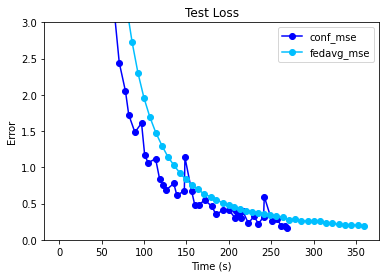

In [15]:
plt.ylim(0, 3)
plt.plot(conf_log, conf_test_mse, color = 'blue', label = 'conf_mse', marker = 'o')
plt.plot(fedavg_log, fedavg_test_mse, color = 'deepskyblue', label = 'fedavg_mse', marker = 'o')
#plt.plot(fedavg_log)
plt.title(f'Test Loss')
plt.ylabel('Error')
plt.xlabel('Time (s)')
plt.legend()


In [16]:
print(conf_test_mse[-1])
print(fedavg_test_mse[-1])

0.16457433998584747
0.19175423681735992


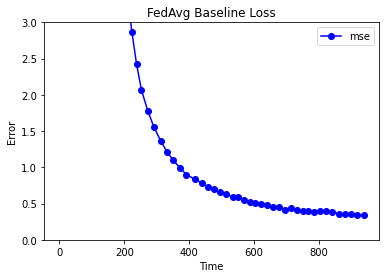

In [ ]:

plt.plot(fedavg_log, fedavg_mse, color = 'blue', label = 'mse', marker = 'o')
#plt.plot(fedavg_log, fedavg_mae, color = 'green', label = 'mae', marker = 'o')
plt.title(f'FedAvg Baseline Loss')
plt.ylabel('Error')
plt.xlabel('Time')
plt.ylim(0, 3)
plt.legend()

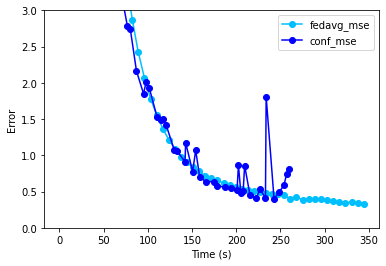

In [10]:
plt.plot(fedavg_log, fedavg_mse, color = 'deepskyblue', label = 'fedavg_mse', marker = 'o')
#plt.plot(fedavg_log, fedavg_mae, color = 'lime', label = 'fedavg_mae', marker = 'o')
plt.plot(log, mse_losses, color = 'blue', label = 'conf_mse', marker = 'o')
#plt.plot(log, mae_losses, color = 'green', label = 'conf_mae', marker = 'o')
plt.ylabel('Error')
plt.xlabel('Time (s)')
plt.ylim(0, 3)
plt.legend()

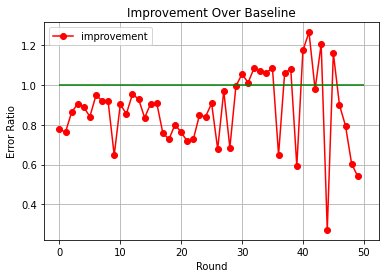

In [11]:
plt.plot((fedavg_log[1:] / log[1:]) * np.array(fedavg_mse[1:]) / np.array(mse_losses[1:]), color = 'red', label = 'improvement', marker = 'o')
plt.title('Improvement Over Baseline')
plt.ylabel('Error Ratio')
plt.xlabel('Round')
plt.hlines(1, 0, 50, color = 'green')
plt.grid()
plt.legend()

In [8]:
mse_losses[1]

332.9375305175781

In [10]:
model = fed.generate_model(w, b)

In [16]:
pred = model.predict(X)
pred

925/925 [==============================] - 1s 1ms/step


array([[30.938416 ],
       [23.234049 ],
       [26.268223 ],
       ...,
       [13.922438 ],
       [ 7.4145555],
       [ 7.3742194]], dtype=float32)

In [30]:
#np.sum(np.absolute(pred - y)) / len(y)
pred = pred.reshape((pred.shape[0],))

In [36]:
np.sum(np.absolute(pred - y) < 0.25) / len(y)

0.6234069166018729

In [12]:
y[0]

31.047

In [13]:
y[1]

23.051

In [14]:
y[-1]

6.9716

In [15]:
y[-2]

7.2991

In [18]:
y[-3]

13.833